In [1]:
import matplotlib.pyplot as plt
from scipy.io import readsav
import numpy as np
import copy
from helita.io import lp
from astropy.io import fits
import sunpy.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing
from skimage.morphology import diamond
import h5py

In [2]:
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'
dpath_area = '/mn/stornext/d9/souvikb/K_means_results/savefiles/'
dpath_cluster_fits= '/mn/stornext/d9/souvikb/K_means_results/'
dpath_timesteps ='/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/calib_tseries/'
dpath_npz = '/mn/stornext/d9/souvikb/K_means_results/'

In [3]:
cluster_mask = fits.getdata(dpath_cluster_fits+'clusters_mask.fits',ext=0)# Reading the Cluster mask time series
hdrH_im =lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
hdrH_sp = lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])
time_sst = readsav(dpath_timesteps+'tseries_3950_2017-05-25T09:12:00_scans=0-424_calib.sav')
time_sst=time_sst['time']
hdr_Mag = lp.getheader(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
dim_Mag = hdr_Mag[0]
cube_Mag = lp.getdata(dpath+'Blos_6302_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cube_Mag = np.reshape(cube_Mag,[dim_Mag[0],dim_Mag[1],dim_Mag[2]])
cube_Mag=np.swapaxes(cube_Mag,0,1)
h_alpha=np.swapaxes(cubeH,0,1)

In [4]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap
mycmap = transparent_cmap(plt.cm.jet)

In [5]:
mean_abs_mag=np.mean(np.abs(cube_Mag),axis=2)

## Blue excursions

In [6]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_blue = [12,48,49,25] # considering the shadows as well. 
master_aux_cube_blue=cluster_mask*0
for clust_index in range(len(cluster_interest_blue)):
    master_aux_cube_blue[np.where(cluster_mask == cluster_interest_blue[clust_index])] = 1.

In [7]:
# Morphological operations as discussed so as to avoid the 1 pixel like connectivities.
# So, we decided to perform morph_open followed by morph_close
selem = diamond(1)
morph_processed_blue = master_aux_cube_blue*0.
for scan in range(425):
    morph_processed_blue[:,:,scan] = binary_closing(binary_opening(master_aux_cube_blue[:,:,scan],selem),selem) # Morph_open followed by Morph_closing operation to get rid of the salt

In [8]:
#labelling the 3d cube
labeled_3d = label(morph_processed_blue,return_num=True, connectivity=2)

In [9]:
labeled_3d[0].shape

(1641, 1518, 425)

In [10]:
print("No. of Blue labels: "+format(labeled_3d[1]))

No. of Blue labels: 23555


In [11]:
# Now creating a bw hit mask based on RPs so that you
# can have an identification which segment of the 3D label 
# belongs to which velocity compartment
cluster_interest_blue_fast=[12,48] #Check COG.ipynb for this 
master_aux_cube_blue_fast=cluster_mask*0
for clust_index in range(len(cluster_interest_blue_fast)):
    master_aux_cube_blue_fast[np.where(cluster_mask == cluster_interest_blue_fast[clust_index])] = 1.

In [12]:
cluster_interest_blue_inter=[49,25] #Check COG.ipynb for this 
master_aux_cube_blue_inter=cluster_mask*0
for clust_index in range(len(cluster_interest_blue_inter)):
    master_aux_cube_blue_inter[np.where(cluster_mask == cluster_interest_blue_inter[clust_index])] = 1.

In [14]:
size = labeled_3d[0].shape
label_3d_blue_fast =  np.zeros((size[0],size[1],size[2]),dtype='int')# should in principle be an integer
label_3d_blue_inter = np.zeros((size[0],size[1],size[2]),dtype='int')
for scan in range(425):
    label_3d_blue_fast[:,:,scan]=master_aux_cube_blue_fast[:,:,scan]*labeled_3d[0][:,:,scan]
    label_3d_blue_inter[:,:,scan]=master_aux_cube_blue_inter[:,:,scan]*labeled_3d[0][:,:,scan]

## Red excursions

In [15]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_red = [18,46,36,26] # considering the shadows as well. 
master_aux_cube_red=cluster_mask*0
for clust_index in range(len(cluster_interest_red)):
    master_aux_cube_red[np.where(cluster_mask == cluster_interest_red[clust_index])] = 1.

In [16]:
selem = diamond(1)
morph_processed_red = master_aux_cube_red*0.
for scan in range(425):
    morph_processed_red[:,:,scan] = binary_closing(binary_opening(master_aux_cube_red[:,:,scan],selem),selem) # Morph_open followed by Morph_closing operation to get rid of the salt

In [17]:
#labelling the 3d cube
labeled_3d_red = label(morph_processed_red,return_num=True, connectivity=2)

In [18]:
print("No. of Red labels :"+format(labeled_3d_red[1]))

No. of Red labels :17962


In [19]:
# Now creating a bw hit mask based on RPs so that you
# can have an identification which segment of the 3D label 
# belongs to which velocity compartment
cluster_interest_red_fast=[18,46] #Check COG.ipynb for this 
master_aux_cube_red_fast=cluster_mask*0
for clust_index in range(len(cluster_interest_red_fast)):
    master_aux_cube_red_fast[np.where(cluster_mask == cluster_interest_red_fast[clust_index])] = 1.

In [20]:
cluster_interest_red_inter=[26,36] #Check COG.ipynb for this 
master_aux_cube_red_inter=cluster_mask*0
for clust_index in range(len(cluster_interest_red_inter)):
    master_aux_cube_red_inter[np.where(cluster_mask == cluster_interest_red_inter[clust_index])] = 1.

In [21]:
label_3d_red_fast =np.zeros((size[0],size[1],size[2]),dtype='int')
label_3d_red_inter =np.zeros((size[0],size[1],size[2]),dtype='int')
for scan in range(425):
    label_3d_red_fast[:,:,scan]=master_aux_cube_red_fast[:,:,scan]*labeled_3d_red[0][:,:,scan]
    label_3d_red_inter[:,:,scan]=master_aux_cube_red_inter[:,:,scan]*labeled_3d_red[0][:,:,scan]

# Plotting as per the paper

## Rapid Red Shifted Excursions 

In [22]:
indices_red_inter_fast_part =np.where(np.isin(label_3d_red_inter,label_3d_red_fast) == True)

In [23]:
common_red_inter = label_3d_red_inter*0
common_red_inter[indices_red_inter_fast_part[0],indices_red_inter_fast_part[1],indices_red_inter_fast_part[2]]=label_3d_red_inter[indices_red_inter_fast_part[0],indices_red_inter_fast_part[1],indices_red_inter_fast_part[2]]

## Rapid blue shifted excursions

In [24]:
indices_blue_inter_fast_part =np.where(np.isin(label_3d_blue_inter,label_3d_blue_fast) == True)

In [25]:
common_blue_inter = label_3d_blue_inter*0
common_blue_inter[indices_blue_inter_fast_part[0],indices_blue_inter_fast_part[1],indices_blue_inter_fast_part[2]]=label_3d_blue_inter[indices_blue_inter_fast_part[0],indices_blue_inter_fast_part[1],indices_blue_inter_fast_part[2]]

In [26]:
number_blue_inter_common = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if common_blue_inter[row,col,:].any()!=0:
            u = np.unique(common_blue_inter[row,col,:])
            number_blue_inter_common[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_inter_common[row,col] = 0.          

In [27]:
number_red_inter_common = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if common_red_inter[row,col,:].any()!=0:
            u = np.unique(common_red_inter[row,col,:])
            number_red_inter_common[row,col] = len(np.where(u!=0)[0])
        else :
            number_red_inter_common[row,col] = 0.          

In [28]:
# Without temporal filtering: without putting a threshold of 140 s as I had done before. 
number_blue_fast = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_blue_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_blue_fast[row,col,:])
            number_blue_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_blue_fast[row,col] = 0.          

In [29]:
# Without temporal filtering: without putting a threshold of 140 s as I had done before. 
number_red_fast = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if label_3d_red_fast[row,col,:].any()!=0:
            u = np.unique(label_3d_red_fast[row,col,:])
            number_red_fast[row,col] = len(np.where(u!=0)[0])
        else :
            number_red_fast[row,col] = 0.          

In [31]:
mask = mean_abs_mag*0
mask[np.where(mean_abs_mag>=100)]=1.

## Plot with **all** the RBEs and RREs associated with the FOV as per the latest clusters

Text(0.5, 0, 'X (Mm)')

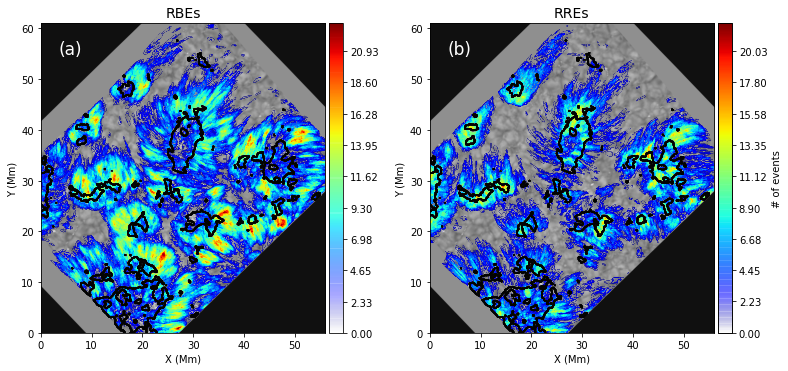

In [32]:
fig, axs =plt.subplots(1,2,figsize=(11,5),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1,wspace=0.2,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()
axs[0].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[0].contourf(number_blue_fast+number_blue_inter_common,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[0].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[0])
cax0 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax0)
#plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].set_title('RBEs',fontsize=14)
axs[0].set_ylabel('Y (Mm)')
axs[0].text(3.5,55,'(a)',color='white',fontsize=17)
axs[0].set_xlabel('X (Mm)')

axs[1].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[1].contourf(number_red_fast+number_red_inter_common,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[1].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax1)
#plt.setp(axs[1].get_xticklabels(), visible=False)
#plt.setp(axs[1].get_yticklabels(), visible=False)
axs[1].set_title('RREs',fontsize=14)
axs[1].text(3.5,55,'(b)',color='white',fontsize=17)
cbar1=plt.colorbar(im,cax=cax1)
cbar1.set_label('# of events')
axs[1].set_ylabel('Y (Mm)')
axs[1].set_xlabel('X (Mm)')

# Coveted Fig 10.

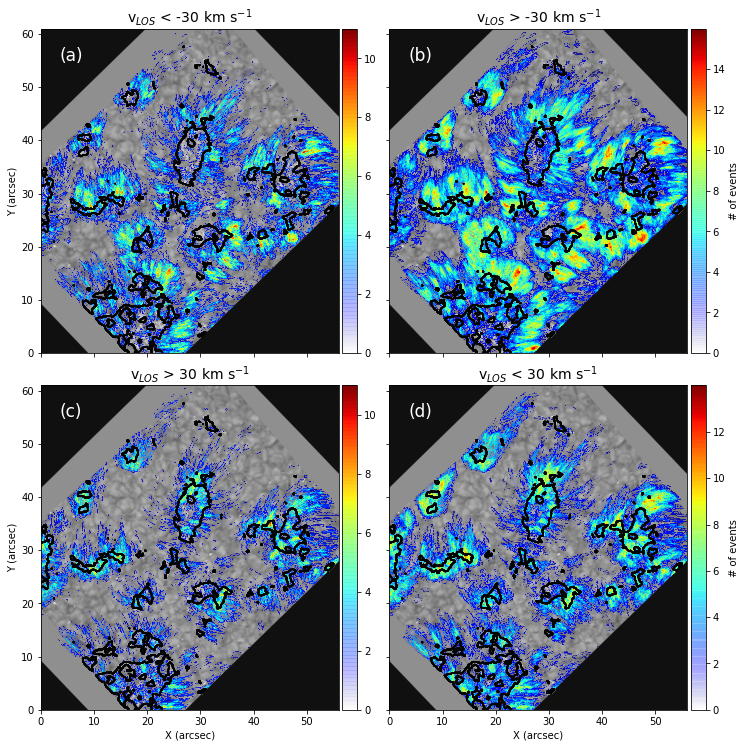

In [46]:
#plot 2:
fig, axs =plt.subplots(2,2,figsize=(10.5,11),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1,wspace=0.05,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()
axs[0].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[0].contourf(number_blue_fast/1.,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[0].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[0])
cax0 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax0,ticks=[0,2,4,6,8,10,12,14])
plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].set_title(r'v$_{LOS}$ < -30 km s$^{-1}$',fontsize=14)
axs[0].set_ylabel('Y (arcsec)')
axs[0].text(3.5,55,'(a)',color='white',fontsize=17)

axs[1].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[1].contourf(number_blue_inter_common/1,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[1].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1=plt.colorbar(im,cax=cax1,ticks=[0,2,4,6,8,10,12,14])
cbar1.set_label('# of events')
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[1].set_title(r'v$_{LOS}$ > -30 km s$^{-1}$',fontsize=14)
axs[1].text(3.5,55,'(b)',color='white',fontsize=17)

# axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
# im=axs[2].contourf(number_blue_slow_common,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
# im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
# plt.setp(axs[2].get_xticklabels(), visible=False)
# plt.setp(axs[2].get_yticklabels(), visible=False)
# divider1 = make_axes_locatable(axs[2])
# cax2 = divider1.append_axes("right", size="5%", pad=0.05)
# cbar2=plt.colorbar(im,cax=cax2,ticks=[0,2,4,6,8,10,12,14])
# cbar2.set_label('# of events')
# axs[2].set_title(r'-29.8 km s$^{-1}$< v$_{LOS}$ < -25.1 km s$^{-1}$',fontsize=14)
# axs[2].text(3.5,55,'(c)',color='white',fontsize=17)

axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[2].contourf(number_red_fast,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[2])
cax3 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax3,ticks=[0,2,4,6,8,10,12])
axs[2].set_title(r'v$_{LOS}$ > 30 km s$^{-1}$',fontsize=14)
axs[2].set_ylabel('Y (arcsec)')
axs[2].set_xlabel('X (arcsec)')
axs[2].text(3.5,55,'(c)',color='white',fontsize=17)
#axs[3].text(36,4,r'N$_{tot}$ = '+format(label_red_fast[1]),color='white',fontsize=13)

axs[3].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[3].contourf(number_red_inter_common,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[3].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[3].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[3])
cax4 = divider1.append_axes("right", size="5%", pad=0.05)
cbar4=plt.colorbar(im,cax=cax4,ticks=[0,2,4,6,8,10,12])
cbar4.set_label('# of events')
axs[3].set_xlabel('X (arcsec)')
axs[3].set_title(r'v$_{LOS}$ < 30 km s$^{-1}$',fontsize=14)
axs[3].text(3.5,55,'(d)',color='white',fontsize=17)
#axs[4].text(36,4,r'N$_{tot}$ = '+format(label_red_inter[1]),color='white',fontsize=13)

# axs[5].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
# im=axs[5].contourf(number_red_slow_common,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
# im1=axs[5].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
# plt.setp(axs[5].get_yticklabels(), visible=False)
# divider1 = make_axes_locatable(axs[5])
# cax5 = divider1.append_axes("right", size="5%", pad=0.05)
# cbar5=plt.colorbar(im,cax=cax5,ticks=[0,2,4,6,8,10,12])
# cbar5.set_label('# of events')
# axs[5].set_title(r'25.1 km s$^{-1}$< v$_{LOS}$ < 29.8 km s$^{-1}$',fontsize=14)
# axs[5].set_xlabel('X (arcsec)')
# axs[5].text(3.5,55,'(f)',color='white',fontsize=17)
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Same_spicules_tracking',dpi=600,format='png')

In [ ]:
### Events that are unique to (b) plus shadows of (b) that are present in (c). Same way for (e) and (f)
indices_red_inter_shadows =np.where(np.isin(label_3d_red_inter,label_3d_red_slow) == True) #check where the common elements between inter and slow are
shadows_red_inter = label_3d_red_inter*0
shadows_red_inter[indices_red_inter_shadows[0],indices_red_inter_shadows[1],indices_red_inter_shadows[2]]=label_3d_red_inter[indices_red_inter_shadows[0],indices_red_inter_shadows[1],indices_red_inter_shadows[2]]

In [38]:
indices_red_inter_filtered_fast = np.where(np.isin(label_3d_red_inter,label_3d_red_fast) == False)
shadows_red_inter_final = label_3d_red_inter*0
shadows_red_inter_final[indices_red_inter_filtered_fast[0],indices_red_inter_filtered_fast[1],indices_red_inter_filtered_fast[2]]=label_3d_red_inter[indices_red_inter_filtered_fast[0],indices_red_inter_filtered_fast[1],indices_red_inter_filtered_fast[2]]

In [39]:
inter_shadows_red = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if shadows_red_inter_final[row,col,:].any()!=0:
            u = np.unique(shadows_red_inter_final[row,col,:])
            inter_shadows_red[row,col] = len(np.where(u!=0)[0])
        else :
            inter_shadows_red[row,col] = 0.          

In [40]:
indices_blue_inter_filtered_fast = np.where(np.isin(label_3d_blue_inter,label_3d_blue_fast) == False)
shadows_blue_inter_final = label_3d_blue_inter*0
shadows_blue_inter_final[indices_blue_inter_filtered_fast[0],indices_blue_inter_filtered_fast[1],indices_blue_inter_filtered_fast[2]]=label_3d_blue_inter[indices_blue_inter_filtered_fast[0],indices_blue_inter_filtered_fast[1],indices_blue_inter_filtered_fast[2]]

In [41]:
inter_shadows_blue = np.zeros((size[0],size[1]))
for row in range(size[0]):
    for col in range(size[1]):
        if shadows_blue_inter_final[row,col,:].any()!=0:
            u = np.unique(shadows_blue_inter_final[row,col,:])
            inter_shadows_blue[row,col] = len(np.where(u!=0)[0])
        else :
            inter_shadows_blue[row,col] = 0.          

# Coveted plot for figure 11

Locator attempting to generate 1001 ticks ([0.0, ..., 10.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1101 ticks ([0.0, ..., 11.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1126 ticks ([0.0, ..., 9.0]), which exceeds Locator.MAXTICKS (1000).


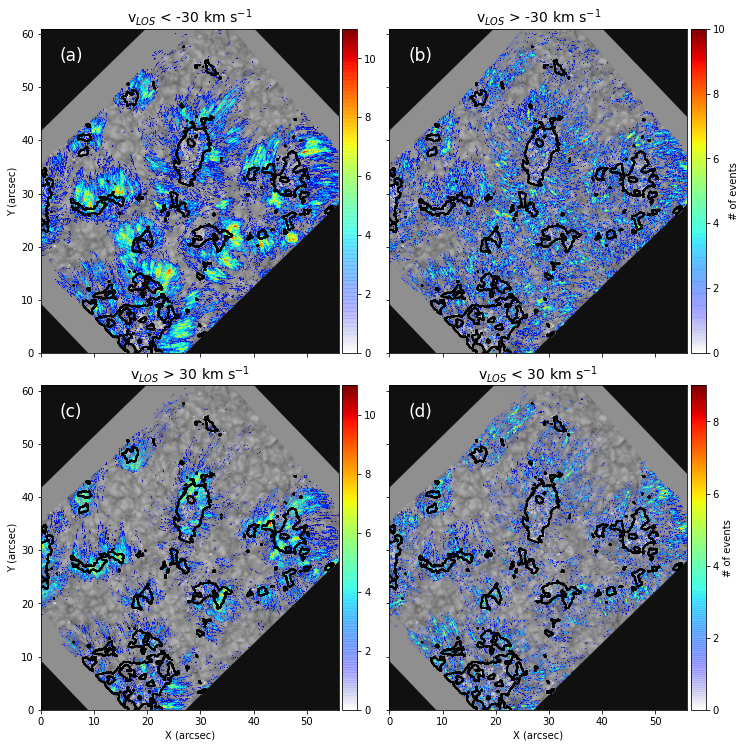

In [47]:
fig, axs =plt.subplots(2,2,figsize=(10.5,11),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1,wspace=0.05,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()
axs[0].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[0].contourf(number_blue_fast/1.,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[0].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[0])
cax0 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax0,ticks=[0, 2, 4, 6, 8, 10])
plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].set_title(r'v$_{LOS}$ < -30 km s$^{-1}$',fontsize=14)
axs[0].set_ylabel('Y (arcsec)')
axs[0].text(3.5,55,'(a)',color='white',fontsize=17)

axs[1].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[1].contourf(inter_shadows_blue,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
im1=axs[1].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1=plt.colorbar(im,cax=cax1,ticks=[0, 2, 4, 6, 8, 10])
cbar1.set_label('# of events')
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[1].set_title(r'v$_{LOS}$ > -30 km s$^{-1}$',fontsize=14)
axs[1].text(3.5,55,'(b)',color='white',fontsize=17)

# axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
# im=axs[2].contourf(number_blue_slow,origin='lower',cmap=mycmap,levels=1000,extent=[0,56,0,61])
# im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
# plt.setp(axs[2].get_xticklabels(), visible=False)
# plt.setp(axs[2].get_yticklabels(), visible=False)
# divider1 = make_axes_locatable(axs[2])
# cax2 = divider1.append_axes("right", size="5%", pad=0.05)
# cbar2=plt.colorbar(im,cax=cax2,ticks=[0, 2, 4, 6, 8, 10])
# cbar2.set_label('# of events')
# axs[2].set_title(r'-29.8 km s$^{-1}$< v$_{LOS}$ < -25.1 km s$^{-1}$',fontsize=14)
# axs[2].text(3.5,55,'(c)',color='white',fontsize=17)

axs[2].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[2].contourf(number_red_fast,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[2].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
divider1 = make_axes_locatable(axs[2])
cax3 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax3,ticks=[0, 2, 4, 6, 8, 10])
axs[2].set_title(r'v$_{LOS}$ > 30 km s$^{-1}$',fontsize=14)
axs[2].set_ylabel('Y (arcsec)')
axs[2].set_xlabel('X (arcsec)')
axs[2].text(3.5,55,'(c)',color='white',fontsize=17)
#axs[3].text(36,4,r'N$_{tot}$ = '+format(label_red_fast[1]),color='white',fontsize=13)

axs[3].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
im=axs[3].contourf(inter_shadows_red,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
im1=axs[3].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
plt.setp(axs[3].get_yticklabels(), visible=False)
divider1 = make_axes_locatable(axs[3])
cax4 = divider1.append_axes("right", size="5%", pad=0.05)
cbar4=plt.colorbar(im,cax=cax4,ticks=[0, 2, 4, 6, 8, 10])
cbar4.set_label('# of events')
axs[3].set_xlabel('X (arcsec)')
axs[3].set_title(r'v$_{LOS}$ < 30 km s$^{-1}$',fontsize=14)
axs[3].text(3.5,55,'(d)',color='white',fontsize=17)
#axs[4].text(36,4,r'N$_{tot}$ = '+format(label_red_inter[1]),color='white',fontsize=13)

# axs[5].imshow(h_alpha[:,:,10,3],origin='lower',cmap='Greys_r',extent=[0,56,0,61])
# im=axs[5].contourf(number_red_slow,origin='lower',cmap=mycmap,levels=1200,extent=[0,56,0,61])
# im1=axs[5].contour(mask,cmap='Greys',levels=110,extent=[0,56,0,61])
# plt.setp(axs[5].get_yticklabels(), visible=False)
# divider1 = make_axes_locatable(axs[5])
# cax5 = divider1.append_axes("right", size="5%", pad=0.05)
# cbar5=plt.colorbar(im,cax=cax5,ticks=[0, 2, 4, 6, 8, 10, 12])
# cbar5.set_label('# of events')
# axs[5].set_title(r'25.1 km s$^{-1}$< v$_{LOS}$ < 29.8 km s$^{-1}$',fontsize=14)
# axs[5].set_xlabel('X (arcsec)')
# axs[5].text(3.5,55,'(f)',color='white',fontsize=17)
plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Unique_spicules_tracking',dpi=600,format='png')

# Saving the required files

In [48]:
## Saving the files for future use ##
import h5py
RBES = number_blue_fast+number_blue_inter_common
RRES = number_red_fast+number_red_inter_common
hf1 = h5py.File('/mn/stornext/d9/souvikb/K_means_results/RBE_map_combined_revised.hdf5', 'w')
hf1.create_dataset('rbes', data=RBES)
hf2 = h5py.File('/mn/stornext/d9/souvikb/K_means_results/RRE_map_combined_revised.hdf5','w')
hf2.create_dataset('rres', data=RRES)
hf1.close()
hf2.close()